In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import keras_tuner as kt

# Konstanta
TRAIN_DIR = 'Datasets/model2/training'
TEST_DIR = 'Datasets/model2/validation'
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_FOLDS = 5
EPOCHS_TUNING = 5
EPOCHS_TRAINING = 30

# Ambil nama kelas dari struktur direktori
class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
num_classes = len(class_names)

# Kumpulkan path dan label
image_paths, labels = [], []
for cls in class_names:
    folder = os.path.join(TRAIN_DIR, cls)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(cls)

# Acak data
image_paths, labels = shuffle(image_paths, labels, random_state=42)
labels_np = np.array([class_names.index(l) for l in labels])

datagen = ImageDataGenerator(rescale=1./255)

Trial 9 Complete [00h 01m 11s]
val_accuracy: 0.00800000037997961

Best val_accuracy So Far: 0.4959999918937683
Total elapsed time: 00h 10m 21s

📊 Hasil Tuning:
   dropout  learning_rate  val_accuracy
0      0.2        0.00100      0.496000
1      0.3        0.00100      0.284000
2      0.4        0.00100      0.153333
3      0.4        0.00010      0.008000
4      0.2        0.00010      0.005333
5      0.3        0.00005      0.004000
6      0.4        0.00005      0.004000
7      0.2        0.00005      0.004000
8      0.3        0.00010      0.004000


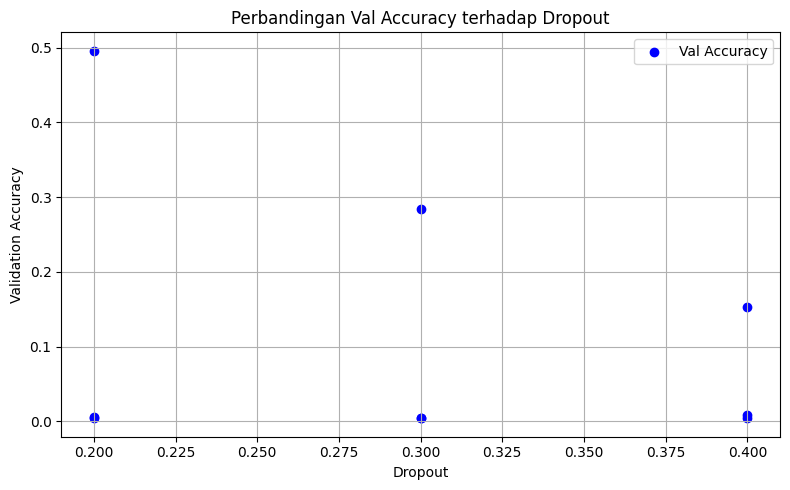

✅ Best Hyperparameters: learning_rate=0.001, dropout=0.2


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras import layers, Model, regularizers
from sklearn.model_selection import StratifiedKFold

# ========== 1. Hyperparameter Tuning (Tanpa K-Fold, Sekali Saja) ==========

# Stratified KFold untuk tuning (1 fold saja)
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
for train_index, val_index in list(skf.split(image_paths, labels_np))[:1]:
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

tune_train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
tune_val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
train_gen_tune = datagen.flow_from_dataframe(
    tune_train_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, classes=class_names
)

val_gen_tune = datagen.flow_from_dataframe(
    tune_val_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False, classes=class_names
)

def build_model(hp):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Unfreeze dari block 6 dan head
    for layer in base_model.layers[:163]:
        layer.trainable = False
    for layer in base_model.layers[163:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 5e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

NUM_TRIALS = 12

print("\n🔍 Memulai hyperparameter tuning...")
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=NUM_TRIALS,
    directory='tuner_dir',
    project_name='efficientnet_finetune_ensemble_v2'
)

tuner.search(train_gen_tune, validation_data=val_gen_tune, epochs=EPOCHS_TUNING, callbacks=[EarlyStopping(patience=2)])

# Ambil semua hasil tuning
trials = tuner.oracle.get_best_trials(num_trials=NUM_TRIALS)
all_results = []
for trial in trials:
    all_results.append({
        'dropout': trial.hyperparameters.get('dropout'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'val_accuracy': trial.score
    })

# Tampilkan hasil tuning
print("\n📊 Hasil Tuning:")
tuning_df = pd.DataFrame(all_results)
print(tuning_df)

# Visualisasi hasil tuning
plt.figure(figsize=(8, 5))
plt.scatter(tuning_df['dropout'], tuning_df['val_accuracy'], c='blue', label='Val Accuracy')
plt.title("Perbandingan Val Accuracy terhadap Dropout")
plt.xlabel("Dropout")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"tuner_dir/efficientnet_finetune_ensemble_v2/efficientnet_tuning_comparison.png")
plt.show()

best_hps = tuner.get_best_hyperparameters(1)[0]
best_lr = best_hps.get('learning_rate')
best_dropout = best_hps.get('dropout')

print(f"✅ Best Hyperparameters: learning_rate={best_lr}, dropout={best_dropout}")


In [5]:
from sklearn.model_selection import StratifiedKFold
# ========== 2. K-Fold Cross Validation ==========
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
labels_array = np.array(labels)

for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels_array)):
    print(f"\n=== Training Fold {fold+1} ===")

    train_df = pd.DataFrame({
        'filename': [image_paths[i] for i in train_idx],
        'class': [labels[i] for i in train_idx]
    })
    val_df = pd.DataFrame({
        'filename': [image_paths[i] for i in val_idx],
        'class': [labels[i] for i in val_idx]
    })

    train_gen = datagen.flow_from_dataframe(
        train_df, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True
    )
    val_gen = datagen.flow_from_dataframe(
        val_df, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    model = build_model(best_hps)
    os.makedirs(f"saved_model_finetune_v2/fold_{fold}/", exist_ok=True)

    acc_checkpoint = ModelCheckpoint(
        filepath=f"saved_model_finetune_v2/fold_{fold}/best_accuracy_model.h5",
        monitor='val_accuracy', mode='max',
        save_best_only=True, verbose=1
    )
    loss_checkpoint = ModelCheckpoint(
        filepath=f"saved_model_finetune_v2/fold_{fold}/best_loss_model.h5",
        monitor='val_loss', mode='min',
        save_best_only=True, verbose=1
    )
    earlystop = EarlyStopping(patience=5, restore_best_weights=True)

    history = model.fit(
        train_gen, validation_data=val_gen,
        epochs=EPOCHS_TRAINING,
        callbacks=[earlystop, acc_checkpoint, loss_checkpoint],
        verbose=1
    )

    # Visualisasi per fold
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(train_acc) + 1)

    # Grafik Akurasi
    plt.figure(figsize=(5, 5))
    plt.plot(epochs_range, train_acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')

    best_val_acc = max(val_acc)
    best_val_acc_epoch = val_acc.index(best_val_acc) + 1
    plt.scatter(best_val_acc_epoch, best_val_acc, color='red', label=f'Best Val Acc: {best_val_acc:.3f}')
    plt.text(best_val_acc_epoch, best_val_acc + 0.01, f'{best_val_acc:.3f}', ha='center', color='red')

    plt.title(f'Accuracy - Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'saved_model_finetune_v2/fold_{fold}/accuracy.png')
    plt.close()

    # Grafik Loss
    plt.figure(figsize=(5, 5))
    plt.plot(epochs_range, train_loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')

    best_val_loss = min(val_loss)
    best_val_loss_epoch = val_loss.index(best_val_loss) + 1
    plt.scatter(best_val_loss_epoch, best_val_loss, color='green', label=f'Best Val Loss: {best_val_loss:.3f}')
    plt.text(best_val_loss_epoch, best_val_loss + 0.01, f'{best_val_loss:.3f}', ha='center', color='green')

    plt.title(f'Loss - Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'saved_model_finetune_v2/fold_{fold}/loss.png')
    plt.close()


=== Training Fold 1 ===
Found 3000 validated image filenames belonging to 220 classes.
Found 750 validated image filenames belonging to 220 classes.
Epoch 1/30


/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.0237 - loss: 5.3009
Epoch 1: val_accuracy improved from -inf to 0.00400, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 5.67587, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 298ms/step - accuracy: 0.0238 - loss: 5.2986 - val_accuracy: 0.0040 - val_loss: 5.6759
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0568 - loss: 4.7284
Epoch 2: val_accuracy improved from 0.00400 to 0.00667, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 2: val_loss did not improve from 5.67587
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.0569 - loss: 4.7275 - val_accuracy: 0.0067 - val_loss: 5.9459
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1198 - loss: 4.1491
Epoch 3: val_accuracy improved from 0.00667 to 0.01467, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 3: val_loss improved from 5.67587 to 5.43711, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1198 - loss: 4.1482 - val_accuracy: 0.0147 - val_loss: 5.4371
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2190 - loss: 3.3956
Epoch 4: val_accuracy improved from 0.01467 to 0.11867, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 4: val_loss improved from 5.43711 to 4.02017, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.2192 - loss: 3.3945 - val_accuracy: 0.1187 - val_loss: 4.0202
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3727 - loss: 2.5219
Epoch 5: val_accuracy improved from 0.11867 to 0.16800, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 5: val_loss improved from 4.02017 to 3.98559, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3730 - loss: 2.5208 - val_accuracy: 0.1680 - val_loss: 3.9856
Epoch 6/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5482 - loss: 1.7288
Epoch 6: val_accuracy improved from 0.16800 to 0.58267, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 6: val_loss improved from 3.98559 to 1.49672, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.5485 - loss: 1.7269 - val_accuracy: 0.5827 - val_loss: 1.4967
Epoch 7/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7224 - loss: 1.0467
Epoch 7: val_accuracy improved from 0.58267 to 0.63333, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 7: val_loss improved from 1.49672 to 1.22376, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.7224 - loss: 1.0464 - val_accuracy: 0.6333 - val_loss: 1.2238
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8004 - loss: 0.7532
Epoch 8: val_accuracy improved from 0.63333 to 0.71333, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 8: val_loss improved from 1.22376 to 0.93055, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8004 - loss: 0.7529 - val_accuracy: 0.7133 - val_loss: 0.9306
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8599 - loss: 0.5514
Epoch 9: val_accuracy improved from 0.71333 to 0.71467, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 9: val_loss did not improve from 0.93055
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8599 - loss: 0.5515 - val_accuracy: 0.7147 - val_loss: 0.9571
Epoch 10/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8809 - loss: 0.4641
Epoch 10: val_accuracy did not improve from 0.71467

Epoch 10: val_loss did not improve from 0.93055
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8811 - loss: 0.4636 - val_accuracy: 0.6760 - val_loss: 1.1064
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9041 - loss: 0.3611
Epoch 11: val_accuracy improved from 0.71467 to 0.85867, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 11: val_loss improved from 0.93055 to 0.47717, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9041 - loss: 0.3611 - val_accuracy: 0.8587 - val_loss: 0.4772
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9307 - loss: 0.2791
Epoch 12: val_accuracy improved from 0.85867 to 0.88800, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 12: val_loss improved from 0.47717 to 0.40322, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9306 - loss: 0.2791 - val_accuracy: 0.8880 - val_loss: 0.4032
Epoch 13/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9271 - loss: 0.2914
Epoch 13: val_accuracy did not improve from 0.88800

Epoch 13: val_loss did not improve from 0.40322
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9272 - loss: 0.2910 - val_accuracy: 0.8427 - val_loss: 0.5435
Epoch 14/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9396 - loss: 0.2410
Epoch 14: val_accuracy did not improve from 0.88800

Epoch 14: val_loss did not improve from 0.40322
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9396 - loss: 0.2406 - val_accuracy: 0.8667 - val_loss: 0.4906
Epoch 15/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9500 - loss: 0.2004
Epoch 15: val_accuracy did not improve from 0.88800

Epoch 15: val_loss did not improve from 0.40322
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9500 - loss: 0.2005 - val_accuracy: 0


Epoch 16: val_loss improved from 0.40322 to 0.35662, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9543 - loss: 0.1803 - val_accuracy: 0.8947 - val_loss: 0.3566
Epoch 17/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9445 - loss: 0.2018
Epoch 17: val_accuracy did not improve from 0.89467

Epoch 17: val_loss did not improve from 0.35662
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9445 - loss: 0.2017 - val_accuracy: 0.8600 - val_loss: 0.4754
Epoch 18/30
84/94 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9543 - loss: 0.1664
Epoch 18: val_accuracy did not improve from 0.89467

Epoch 18: val_loss improved from 0.35662 to 0.34254, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9548 - loss: 0.1656 - val_accuracy: 0.8920 - val_loss: 0.3425
Epoch 19/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9562 - loss: 0.1585
Epoch 19: val_accuracy did not improve from 0.89467

Epoch 19: val_loss did not improve from 0.34254
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9561 - loss: 0.1587 - val_accuracy: 0.8773 - val_loss: 0.4731
Epoch 20/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9532 - loss: 0.1756
Epoch 20: val_accuracy improved from 0.89467 to 0.90933, saving model to saved_model_finetune_v2/fold_0/best_accuracy_model.h5



Epoch 20: val_loss improved from 0.34254 to 0.29373, saving model to saved_model_finetune_v2/fold_0/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9533 - loss: 0.1753 - val_accuracy: 0.9093 - val_loss: 0.2937
Epoch 21/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9510 - loss: 0.1600
Epoch 21: val_accuracy did not improve from 0.90933

Epoch 21: val_loss did not improve from 0.29373
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9511 - loss: 0.1602 - val_accuracy: 0.8987 - val_loss: 0.3213
Epoch 22/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9644 - loss: 0.1405
Epoch 22: val_accuracy did not improve from 0.90933

Epoch 22: val_loss did not improve from 0.29373
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9645 - loss: 0.1402 - val_accuracy: 0.9093 - val_loss: 0.3029
Epoch 23/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9654 - loss: 0.1167
Epoch 23: val_accuracy did not improve from 0.90933

Epoch 23: val_loss did not improve from 0.29373
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9654 - loss: 0.1168 - val_accuracy: 

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.0239 - loss: 5.2710
Epoch 1: val_accuracy improved from -inf to 0.00267, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 5.76215, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 274ms/step - accuracy: 0.0239 - loss: 5.2701 - val_accuracy: 0.0027 - val_loss: 5.7622
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0419 - loss: 4.8875
Epoch 2: val_accuracy did not improve from 0.00267

Epoch 2: val_loss improved from 5.76215 to 5.74893, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.0420 - loss: 4.8863 - val_accuracy: 0.0027 - val_loss: 5.7489
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.0830 - loss: 4.4312
Epoch 3: val_accuracy improved from 0.00267 to 0.02800, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 3: val_loss improved from 5.74893 to 5.12566, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.0831 - loss: 4.4299 - val_accuracy: 0.0280 - val_loss: 5.1257
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1675 - loss: 3.7456
Epoch 4: val_accuracy improved from 0.02800 to 0.08400, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 4: val_loss improved from 5.12566 to 4.36890, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.1676 - loss: 3.7445 - val_accuracy: 0.0840 - val_loss: 4.3689
Epoch 5/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2883 - loss: 2.9525
Epoch 5: val_accuracy improved from 0.08400 to 0.12533, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 5: val_loss improved from 4.36890 to 3.99354, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.2888 - loss: 2.9490 - val_accuracy: 0.1253 - val_loss: 3.9935
Epoch 6/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5094 - loss: 1.9641
Epoch 6: val_accuracy improved from 0.12533 to 0.34933, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 6: val_loss improved from 3.99354 to 2.51975, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5095 - loss: 1.9625 - val_accuracy: 0.3493 - val_loss: 2.5198
Epoch 7/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6424 - loss: 1.3045
Epoch 7: val_accuracy did not improve from 0.34933

Epoch 7: val_loss did not improve from 2.51975
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6424 - loss: 1.3043 - val_accuracy: 0.2413 - val_loss: 3.3031
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7662 - loss: 0.9291
Epoch 8: val_accuracy improved from 0.34933 to 0.63200, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 8: val_loss improved from 2.51975 to 1.20869, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7662 - loss: 0.9284 - val_accuracy: 0.6320 - val_loss: 1.2087
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8428 - loss: 0.6038
Epoch 9: val_accuracy improved from 0.63200 to 0.75467, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 9: val_loss improved from 1.20869 to 0.77840, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8428 - loss: 0.6039 - val_accuracy: 0.7547 - val_loss: 0.7784
Epoch 10/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8617 - loss: 0.5394
Epoch 10: val_accuracy improved from 0.75467 to 0.81200, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 10: val_loss improved from 0.77840 to 0.63144, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8618 - loss: 0.5389 - val_accuracy: 0.8120 - val_loss: 0.6314
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8933 - loss: 0.4213
Epoch 11: val_accuracy improved from 0.81200 to 0.83867, saving model to saved_model_finetune_v2/fold_1/best_accuracy_model.h5



Epoch 11: val_loss improved from 0.63144 to 0.51870, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8932 - loss: 0.4214 - val_accuracy: 0.8387 - val_loss: 0.5187
Epoch 12/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8998 - loss: 0.4075
Epoch 12: val_accuracy did not improve from 0.83867

Epoch 12: val_loss did not improve from 0.51870
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8999 - loss: 0.4070 - val_accuracy: 0.7893 - val_loss: 0.6612
Epoch 13/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9127 - loss: 0.3525
Epoch 13: val_accuracy did not improve from 0.83867

Epoch 13: val_loss did not improve from 0.51870
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9127 - loss: 0.3523 - val_accuracy: 0.8080 - val_loss: 0.6656
Epoch 14/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9252 - loss: 0.3247
Epoch 14: val_accuracy did not improve from 0.83867

Epoch 14: val_loss did not improve from 0.51870
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9252 - loss: 0.3246 - val_accuracy: 0


Epoch 15: val_loss improved from 0.51870 to 0.27883, saving model to saved_model_finetune_v2/fold_1/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9439 - loss: 0.2276 - val_accuracy: 0.9093 - val_loss: 0.2788
Epoch 16/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9388 - loss: 0.2301
Epoch 16: val_accuracy did not improve from 0.90933

Epoch 16: val_loss did not improve from 0.27883
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9388 - loss: 0.2304 - val_accuracy: 0.8733 - val_loss: 0.4088
Epoch 17/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9451 - loss: 0.2134
Epoch 17: val_accuracy did not improve from 0.90933

Epoch 17: val_loss did not improve from 0.27883
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9450 - loss: 0.2136 - val_accuracy: 0.8653 - val_loss: 0.4233
Epoch 18/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9536 - loss: 0.1666
Epoch 18: val_accuracy did not improve from 0.90933

Epoch 18: val_loss did not improve from 0.27883
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9536 - loss: 0.1667 - val_accuracy: 0

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.0202 - loss: 5.3031
Epoch 1: val_accuracy improved from -inf to 0.00667, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 5.74716, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 50s 276ms/step - accuracy: 0.0203 - loss: 5.3019 - val_accuracy: 0.0067 - val_loss: 5.7472
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0453 - loss: 4.8058
Epoch 2: val_accuracy did not improve from 0.00667

Epoch 2: val_loss improved from 5.74716 to 5.68253, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.0454 - loss: 4.8050 - val_accuracy: 0.0067 - val_loss: 5.6825
Epoch 3/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0907 - loss: 4.2957
Epoch 3: val_accuracy improved from 0.00667 to 0.00933, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 3: val_loss improved from 5.68253 to 5.25098, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.0909 - loss: 4.2931 - val_accuracy: 0.0093 - val_loss: 5.2510
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1725 - loss: 3.5928
Epoch 4: val_accuracy improved from 0.00933 to 0.09333, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 4: val_loss improved from 5.25098 to 4.28302, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.1728 - loss: 3.5912 - val_accuracy: 0.0933 - val_loss: 4.2830
Epoch 5/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3387 - loss: 2.6819
Epoch 5: val_accuracy improved from 0.09333 to 0.34133, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 5: val_loss improved from 4.28302 to 2.64821, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3391 - loss: 2.6784 - val_accuracy: 0.3413 - val_loss: 2.6482
Epoch 6/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5246 - loss: 1.8594
Epoch 6: val_accuracy improved from 0.34133 to 0.37200, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 6: val_loss improved from 2.64821 to 2.53636, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5255 - loss: 1.8555 - val_accuracy: 0.3720 - val_loss: 2.5364
Epoch 7/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6854 - loss: 1.1418
Epoch 7: val_accuracy improved from 0.37200 to 0.37733, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 7: val_loss improved from 2.53636 to 2.48125, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.6855 - loss: 1.1413 - val_accuracy: 0.3773 - val_loss: 2.4813
Epoch 8/30
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7973 - loss: 0.7646
Epoch 8: val_accuracy improved from 0.37733 to 0.53867, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 8: val_loss improved from 2.48125 to 1.63435, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7971 - loss: 0.7643 - val_accuracy: 0.5387 - val_loss: 1.6344
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8494 - loss: 0.5601
Epoch 9: val_accuracy improved from 0.53867 to 0.78933, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 9: val_loss improved from 1.63435 to 0.69901, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8494 - loss: 0.5603 - val_accuracy: 0.7893 - val_loss: 0.6990
Epoch 10/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8827 - loss: 0.4420
Epoch 10: val_accuracy improved from 0.78933 to 0.80533, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 10: val_loss improved from 0.69901 to 0.64737, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8829 - loss: 0.4418 - val_accuracy: 0.8053 - val_loss: 0.6474
Epoch 11/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8966 - loss: 0.3751
Epoch 11: val_accuracy improved from 0.80533 to 0.86800, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 11: val_loss improved from 0.64737 to 0.45706, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8968 - loss: 0.3744 - val_accuracy: 0.8680 - val_loss: 0.4571
Epoch 12/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9267 - loss: 0.3100
Epoch 12: val_accuracy did not improve from 0.86800

Epoch 12: val_loss did not improve from 0.45706
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9266 - loss: 0.3100 - val_accuracy: 0.7680 - val_loss: 0.7681
Epoch 13/30
82/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9316 - loss: 0.2529
Epoch 13: val_accuracy did not improve from 0.86800

Epoch 13: val_loss did not improve from 0.45706
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9314 - loss: 0.2550 - val_accuracy: 0.8080 - val_loss: 0.5978
Epoch 14/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.2347
Epoch 14: val_accuracy improved from 0.86800 to 0.89067, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 14: val_loss improved from 0.45706 to 0.37396, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9391 - loss: 0.2353 - val_accuracy: 0.8907 - val_loss: 0.3740
Epoch 15/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9438 - loss: 0.2160
Epoch 15: val_accuracy did not improve from 0.89067

Epoch 15: val_loss did not improve from 0.37396
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9438 - loss: 0.2161 - val_accuracy: 0.8907 - val_loss: 0.3781
Epoch 16/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9379 - loss: 0.2253
Epoch 16: val_accuracy did not improve from 0.89067

Epoch 16: val_loss did not improve from 0.37396
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9378 - loss: 0.2255 - val_accuracy: 0.8733 - val_loss: 0.4535
Epoch 17/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9353 - loss: 0.2456
Epoch 17: val_accuracy improved from 0.89067 to 0.89200, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 17: val_loss improved from 0.37396 to 0.35669, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9354 - loss: 0.2451 - val_accuracy: 0.8920 - val_loss: 0.3567
Epoch 18/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9633 - loss: 0.1463
Epoch 18: val_accuracy did not improve from 0.89200

Epoch 18: val_loss did not improve from 0.35669
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9631 - loss: 0.1468 - val_accuracy: 0.8587 - val_loss: 0.4532
Epoch 19/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9617 - loss: 0.1581
Epoch 19: val_accuracy did not improve from 0.89200

Epoch 19: val_loss did not improve from 0.35669
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9617 - loss: 0.1580 - val_accuracy: 0.8720 - val_loss: 0.4041
Epoch 20/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9592 - loss: 0.1383
Epoch 20: val_accuracy improved from 0.89200 to 0.90533, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 20: val_loss improved from 0.35669 to 0.32278, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9592 - loss: 0.1383 - val_accuracy: 0.9053 - val_loss: 0.3228
Epoch 21/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9636 - loss: 0.1583
Epoch 21: val_accuracy did not improve from 0.90533

Epoch 21: val_loss did not improve from 0.32278
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9636 - loss: 0.1585 - val_accuracy: 0.8867 - val_loss: 0.4401
Epoch 22/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9614 - loss: 0.1398
Epoch 22: val_accuracy did not improve from 0.90533

Epoch 22: val_loss did not improve from 0.32278
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9615 - loss: 0.1398 - val_accuracy: 0.8907 - val_loss: 0.3310
Epoch 23/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9662 - loss: 0.1293
Epoch 23: val_accuracy did not improve from 0.90533

Epoch 23: val_loss did not improve from 0.32278
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9661 - loss: 0.1296 - val_accuracy: 0


Epoch 24: val_loss improved from 0.32278 to 0.25883, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9627 - loss: 0.1395 - val_accuracy: 0.9187 - val_loss: 0.2588
Epoch 25/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9683 - loss: 0.1305
Epoch 25: val_accuracy did not improve from 0.91867

Epoch 25: val_loss did not improve from 0.25883
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9682 - loss: 0.1308 - val_accuracy: 0.8933 - val_loss: 0.3763
Epoch 26/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9659 - loss: 0.1299
Epoch 26: val_accuracy improved from 0.91867 to 0.92000, saving model to saved_model_finetune_v2/fold_2/best_accuracy_model.h5



Epoch 26: val_loss improved from 0.25883 to 0.25510, saving model to saved_model_finetune_v2/fold_2/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9659 - loss: 0.1300 - val_accuracy: 0.9200 - val_loss: 0.2551
Epoch 27/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9680 - loss: 0.1129
Epoch 27: val_accuracy did not improve from 0.92000

Epoch 27: val_loss did not improve from 0.25510
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9680 - loss: 0.1130 - val_accuracy: 0.8773 - val_loss: 0.4211
Epoch 28/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9609 - loss: 0.1239
Epoch 28: val_accuracy did not improve from 0.92000

Epoch 28: val_loss did not improve from 0.25510
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9610 - loss: 0.1239 - val_accuracy: 0.8893 - val_loss: 0.3530
Epoch 29/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9762 - loss: 0.0927
Epoch 29: val_accuracy did not improve from 0.92000

Epoch 29: val_loss did not improve from 0.25510
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9761 - loss: 0.0929 - val_accuracy: 0

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.0151 - loss: 5.3473
Epoch 1: val_accuracy improved from -inf to 0.00400, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 5.84649, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.0153 - loss: 5.3448 - val_accuracy: 0.0040 - val_loss: 5.8465
Epoch 2/30
78/94 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0373 - loss: 4.9294
Epoch 2: val_accuracy improved from 0.00400 to 0.00933, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 2: val_loss improved from 5.84649 to 5.63265, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.0383 - loss: 4.9127 - val_accuracy: 0.0093 - val_loss: 5.6326
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0791 - loss: 4.3974
Epoch 3: val_accuracy improved from 0.00933 to 0.01600, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 3: val_loss improved from 5.63265 to 5.62016, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.0793 - loss: 4.3964 - val_accuracy: 0.0160 - val_loss: 5.6202
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1426 - loss: 3.8134
Epoch 4: val_accuracy improved from 0.01600 to 0.04133, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 4: val_loss improved from 5.62016 to 5.08153, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.1428 - loss: 3.8122 - val_accuracy: 0.0413 - val_loss: 5.0815
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2708 - loss: 3.0121
Epoch 5: val_accuracy improved from 0.04133 to 0.13067, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 5: val_loss improved from 5.08153 to 3.93276, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.2711 - loss: 3.0103 - val_accuracy: 0.1307 - val_loss: 3.9328
Epoch 6/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4830 - loss: 2.0366
Epoch 6: val_accuracy improved from 0.13067 to 0.33467, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 6: val_loss improved from 3.93276 to 2.64146, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.4834 - loss: 2.0336 - val_accuracy: 0.3347 - val_loss: 2.6415
Epoch 7/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6572 - loss: 1.3034
Epoch 7: val_accuracy improved from 0.33467 to 0.44000, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 7: val_loss improved from 2.64146 to 2.00006, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.6575 - loss: 1.3019 - val_accuracy: 0.4400 - val_loss: 2.0001
Epoch 8/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7709 - loss: 0.8838
Epoch 8: val_accuracy improved from 0.44000 to 0.78267, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 8: val_loss improved from 2.00006 to 0.73625, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7710 - loss: 0.8830 - val_accuracy: 0.7827 - val_loss: 0.7363
Epoch 9/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8218 - loss: 0.6747
Epoch 9: val_accuracy did not improve from 0.78267

Epoch 9: val_loss did not improve from 0.73625
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8218 - loss: 0.6744 - val_accuracy: 0.6307 - val_loss: 1.1563
Epoch 10/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8876 - loss: 0.4458
Epoch 10: val_accuracy did not improve from 0.78267

Epoch 10: val_loss did not improve from 0.73625
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8874 - loss: 0.4466 - val_accuracy: 0.7520 - val_loss: 0.7499
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9044 - loss: 0.3499
Epoch 11: val_accuracy improved from 0.78267 to 0.79200, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 11: val_loss improved from 0.73625 to 0.65773, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9043 - loss: 0.3504 - val_accuracy: 0.7920 - val_loss: 0.6577
Epoch 12/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9104 - loss: 0.3456
Epoch 12: val_accuracy did not improve from 0.79200

Epoch 12: val_loss did not improve from 0.65773
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9103 - loss: 0.3459 - val_accuracy: 0.7627 - val_loss: 0.7885
Epoch 13/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9345 - loss: 0.2735
Epoch 13: val_accuracy did not improve from 0.79200

Epoch 13: val_loss did not improve from 0.65773
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9344 - loss: 0.2737 - val_accuracy: 0.6840 - val_loss: 1.0316
Epoch 14/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9303 - loss: 0.2817
Epoch 14: val_accuracy improved from 0.79200 to 0.84000, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 14: val_loss improved from 0.65773 to 0.50820, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9302 - loss: 0.2816 - val_accuracy: 0.8400 - val_loss: 0.5082
Epoch 15/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9422 - loss: 0.2195
Epoch 15: val_accuracy did not improve from 0.84000

Epoch 15: val_loss did not improve from 0.50820
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9421 - loss: 0.2201 - val_accuracy: 0.7013 - val_loss: 1.0047
Epoch 16/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9392 - loss: 0.2101
Epoch 16: val_accuracy improved from 0.84000 to 0.86000, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 16: val_loss improved from 0.50820 to 0.42827, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9393 - loss: 0.2100 - val_accuracy: 0.8600 - val_loss: 0.4283
Epoch 17/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9519 - loss: 0.1666
Epoch 17: val_accuracy improved from 0.86000 to 0.86667, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 17: val_loss did not improve from 0.42827
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9518 - loss: 0.1668 - val_accuracy: 0.8667 - val_loss: 0.4456
Epoch 18/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9493 - loss: 0.1914
Epoch 18: val_accuracy did not improve from 0.86667

Epoch 18: val_loss did not improve from 0.42827
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9492 - loss: 0.1917 - val_accuracy: 0.8467 - val_loss: 0.4919
Epoch 19/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9476 - loss: 0.2037
Epoch 19: val_accuracy improved from 0.86667 to 0.88000, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 19: val_loss improved from 0.42827 to 0.38047, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9476 - loss: 0.2035 - val_accuracy: 0.8800 - val_loss: 0.3805
Epoch 20/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9623 - loss: 0.1387
Epoch 20: val_accuracy improved from 0.88000 to 0.89467, saving model to saved_model_finetune_v2/fold_3/best_accuracy_model.h5



Epoch 20: val_loss did not improve from 0.38047
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9623 - loss: 0.1388 - val_accuracy: 0.8947 - val_loss: 0.3947
Epoch 21/30
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9636 - loss: 0.1366
Epoch 21: val_accuracy did not improve from 0.89467

Epoch 21: val_loss did not improve from 0.38047
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9632 - loss: 0.1381 - val_accuracy: 0.8080 - val_loss: 0.6267
Epoch 22/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9593 - loss: 0.1697
Epoch 22: val_accuracy did not improve from 0.89467

Epoch 22: val_loss improved from 0.38047 to 0.35948, saving model to saved_model_finetune_v2/fold_3/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9593 - loss: 0.1694 - val_accuracy: 0.8920 - val_loss: 0.3595
Epoch 23/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9608 - loss: 0.1461
Epoch 23: val_accuracy did not improve from 0.89467

Epoch 23: val_loss did not improve from 0.35948
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9608 - loss: 0.1461 - val_accuracy: 0.7880 - val_loss: 0.6923
Epoch 24/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9688 - loss: 0.1249
Epoch 24: val_accuracy did not improve from 0.89467

Epoch 24: val_loss did not improve from 0.35948
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9687 - loss: 0.1250 - val_accuracy: 0.8907 - val_loss: 0.3635
Epoch 25/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9704 - loss: 0.1243
Epoch 25: val_accuracy did not improve from 0.89467

Epoch 25: val_loss did not improve from 0.35948
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9703 - loss: 0.1244 - val_accuracy: 0

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.0226 - loss: 5.3024
Epoch 1: val_accuracy improved from -inf to 0.00667, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 5.80067, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 278ms/step - accuracy: 0.0228 - loss: 5.3001 - val_accuracy: 0.0067 - val_loss: 5.8007
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0362 - loss: 4.8732
Epoch 2: val_accuracy did not improve from 0.00667

Epoch 2: val_loss improved from 5.80067 to 5.54284, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.0363 - loss: 4.8719 - val_accuracy: 0.0067 - val_loss: 5.5428
Epoch 3/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0959 - loss: 4.3185
Epoch 3: val_accuracy improved from 0.00667 to 0.01467, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 3: val_loss did not improve from 5.54284
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.0962 - loss: 4.3160 - val_accuracy: 0.0147 - val_loss: 5.7225
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1837 - loss: 3.5953
Epoch 4: val_accuracy improved from 0.01467 to 0.04267, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 4: val_loss did not improve from 5.54284
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.1838 - loss: 3.5943 - val_accuracy: 0.0427 - val_loss: 5.5745
Epoch 5/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3366 - loss: 2.7897
Epoch 5: val_accuracy improved from 0.04267 to 0.31867, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 5: val_loss improved from 5.54284 to 2.75340, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.3371 - loss: 2.7859 - val_accuracy: 0.3187 - val_loss: 2.7534
Epoch 6/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5241 - loss: 1.7935
Epoch 6: val_accuracy improved from 0.31867 to 0.52933, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 6: val_loss improved from 2.75340 to 1.65803, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5247 - loss: 1.7911 - val_accuracy: 0.5293 - val_loss: 1.6580
Epoch 7/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6866 - loss: 1.1738
Epoch 7: val_accuracy did not improve from 0.52933

Epoch 7: val_loss did not improve from 1.65803
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6869 - loss: 1.1724 - val_accuracy: 0.5053 - val_loss: 1.8059
Epoch 8/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8122 - loss: 0.7119
Epoch 8: val_accuracy improved from 0.52933 to 0.68933, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 8: val_loss improved from 1.65803 to 1.00339, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8121 - loss: 0.7119 - val_accuracy: 0.6893 - val_loss: 1.0034
Epoch 9/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8540 - loss: 0.5492
Epoch 9: val_accuracy improved from 0.68933 to 0.78000, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 9: val_loss improved from 1.00339 to 0.72954, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8540 - loss: 0.5491 - val_accuracy: 0.7800 - val_loss: 0.7295
Epoch 10/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9066 - loss: 0.3890
Epoch 10: val_accuracy improved from 0.78000 to 0.81333, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 10: val_loss improved from 0.72954 to 0.62028, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9064 - loss: 0.3897 - val_accuracy: 0.8133 - val_loss: 0.6203
Epoch 11/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9047 - loss: 0.3646
Epoch 11: val_accuracy did not improve from 0.81333

Epoch 11: val_loss improved from 0.62028 to 0.61920, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9048 - loss: 0.3645 - val_accuracy: 0.8040 - val_loss: 0.6192
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9278 - loss: 0.2911
Epoch 12: val_accuracy did not improve from 0.81333

Epoch 12: val_loss did not improve from 0.61920
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9277 - loss: 0.2913 - val_accuracy: 0.7920 - val_loss: 0.7306
Epoch 13/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9251 - loss: 0.2593
Epoch 13: val_accuracy improved from 0.81333 to 0.83733, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 13: val_loss improved from 0.61920 to 0.54353, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9250 - loss: 0.2599 - val_accuracy: 0.8373 - val_loss: 0.5435
Epoch 14/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9406 - loss: 0.2215
Epoch 14: val_accuracy improved from 0.83733 to 0.86400, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 14: val_loss improved from 0.54353 to 0.41877, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9405 - loss: 0.2217 - val_accuracy: 0.8640 - val_loss: 0.4188
Epoch 15/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9453 - loss: 0.2275
Epoch 15: val_accuracy did not improve from 0.86400

Epoch 15: val_loss did not improve from 0.41877
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9452 - loss: 0.2276 - val_accuracy: 0.8107 - val_loss: 0.6585
Epoch 16/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9445 - loss: 0.2116
Epoch 16: val_accuracy improved from 0.86400 to 0.89200, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 16: val_loss improved from 0.41877 to 0.37823, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9445 - loss: 0.2118 - val_accuracy: 0.8920 - val_loss: 0.3782
Epoch 17/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9440 - loss: 0.2010
Epoch 17: val_accuracy did not improve from 0.89200

Epoch 17: val_loss improved from 0.37823 to 0.36949, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9439 - loss: 0.2011 - val_accuracy: 0.8867 - val_loss: 0.3695
Epoch 18/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9619 - loss: 0.1462
Epoch 18: val_accuracy did not improve from 0.89200

Epoch 18: val_loss improved from 0.36949 to 0.35920, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9618 - loss: 0.1465 - val_accuracy: 0.8853 - val_loss: 0.3592
Epoch 19/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9465 - loss: 0.2105
Epoch 19: val_accuracy did not improve from 0.89200

Epoch 19: val_loss did not improve from 0.35920
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9465 - loss: 0.2100 - val_accuracy: 0.8853 - val_loss: 0.3872
Epoch 20/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9595 - loss: 0.1259
Epoch 20: val_accuracy did not improve from 0.89200

Epoch 20: val_loss did not improve from 0.35920
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9595 - loss: 0.1259 - val_accuracy: 0.8773 - val_loss: 0.3989
Epoch 21/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9620 - loss: 0.1368
Epoch 21: val_accuracy improved from 0.89200 to 0.89333, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 21: val_loss improved from 0.35920 to 0.34793, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9620 - loss: 0.1369 - val_accuracy: 0.8933 - val_loss: 0.3479
Epoch 22/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9709 - loss: 0.1124
Epoch 22: val_accuracy improved from 0.89333 to 0.92133, saving model to saved_model_finetune_v2/fold_4/best_accuracy_model.h5



Epoch 22: val_loss improved from 0.34793 to 0.26404, saving model to saved_model_finetune_v2/fold_4/best_loss_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9709 - loss: 0.1124 - val_accuracy: 0.9213 - val_loss: 0.2640
Epoch 23/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9640 - loss: 0.1202
Epoch 23: val_accuracy did not improve from 0.92133

Epoch 23: val_loss did not improve from 0.26404
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9640 - loss: 0.1202 - val_accuracy: 0.8867 - val_loss: 0.3862
Epoch 24/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9733 - loss: 0.1146
Epoch 24: val_accuracy did not improve from 0.92133

Epoch 24: val_loss did not improve from 0.26404
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9732 - loss: 0.1148 - val_accuracy: 0.8640 - val_loss: 0.4381
Epoch 25/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9668 - loss: 0.1236
Epoch 25: val_accuracy did not improve from 0.92133

Epoch 25: val_loss did not improve from 0.26404
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9669 - loss: 0.1235 - val_accuracy: 0

Found 944 images belonging to 220 classes.

Evaluating Fold 0 - accuracy model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step
F1-Score: 0.8910
              precision    recall  f1-score   support

        abah       0.60      1.00      0.75         6
       acara       1.00      1.00      1.00         3
        agul       0.75      1.00      0.86         3
          ai       1.00      0.67      0.80         3
         aki       0.33      0.67      0.44         3
        akur       1.00      0.67      0.80         3
      angkat       1.00      1.00      1.00         3
        apal       1.00      1.00      1.00         3
        asup       1.00      1.00      1.00         3
        asép       1.00      1.00      1.00         3
        atuh       1.00      0.67      0.80         3
         aya       0.86      1.00      0.92         6
       ayana       1.00      1.00      1.00         3
      ayeuna       1.00      0.83      0.91         6
       bahar       0.75      1.00      0.86         3
       bakal       1.00      1.00      1.00         3
        balé       1.0

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

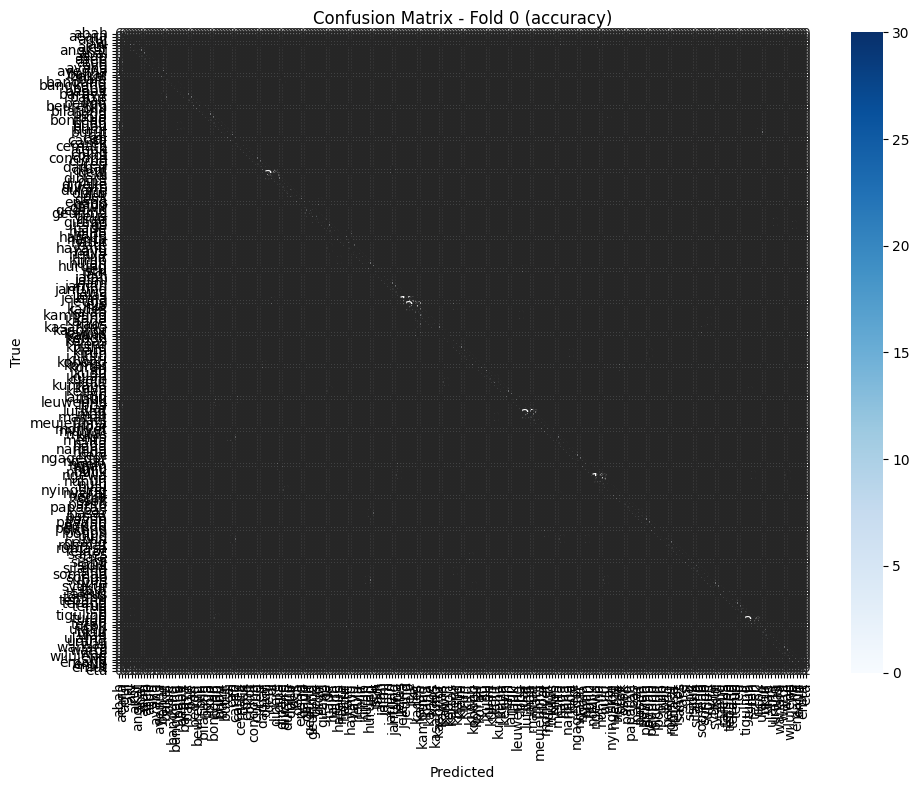


Evaluating Fold 1 - accuracy model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step
F1-Score: 0.8640
              precision    recall  f1-score   support

        abah       0.83      0.83      0.83         6
       acara       1.00      1.00      1.00         3
        agul       0.75      1.00      0.86         3
          ai       1.00      1.00      1.00         3
         aki       0.33      0.67      0.44         3
        akur       0.00      0.00      0.00         3
      angkat       0.75      1.00      0.86         3
        apal       1.00      1.00      1.00         3
        asup       1.00      1.00      1.00         3
        asép       1.00      1.00      1.00         3
        atuh       0.75      1.00      0.86         3
         aya       1.00      0.67      0.80         6
       ayana       0.75      1.00      0.86         3
      ayeuna       1.00      0.83      0.91         6
       bahar       0.50      0.33      0.40         3
       bakal       1.00      1.00      1.00         3
        balé       0.86

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

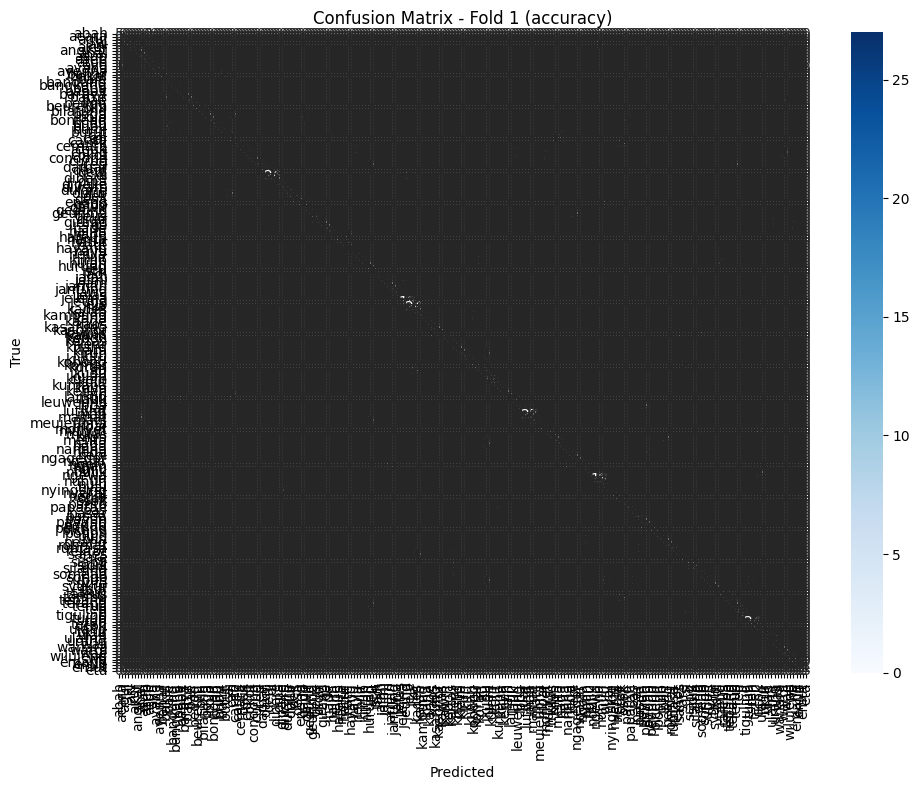


Evaluating Fold 2 - accuracy model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step
F1-Score: 0.8842
              precision    recall  f1-score   support

        abah       1.00      0.83      0.91         6
       acara       1.00      1.00      1.00         3
        agul       0.67      0.67      0.67         3
          ai       0.75      1.00      0.86         3
         aki       0.00      0.00      0.00         3
        akur       0.50      1.00      0.67         3
      angkat       0.75      1.00      0.86         3
        apal       1.00      1.00      1.00         3
        asup       0.75      1.00      0.86         3
        asép       1.00      1.00      1.00         3
        atuh       0.75      1.00      0.86         3
         aya       1.00      0.83      0.91         6
       ayana       1.00      1.00      1.00         3
      ayeuna       1.00      1.00      1.00         6
       bahar       0.75      1.00      0.86         3
       bakal       1.00      1.00      1.00         3
        balé       0.71

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

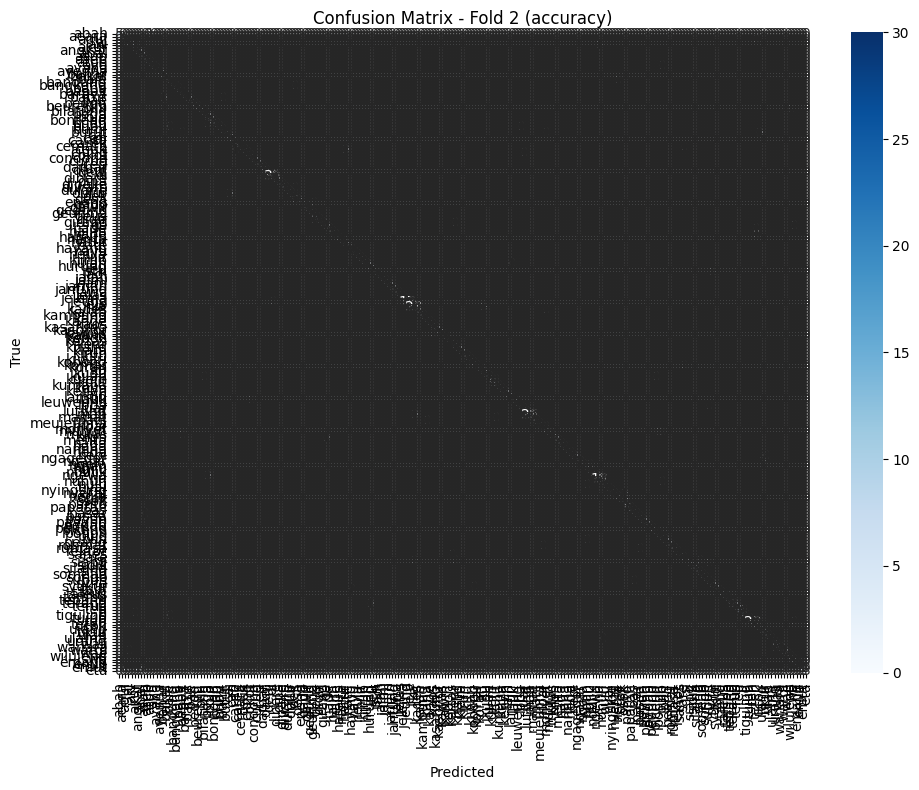


Evaluating Fold 3 - accuracy model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step
F1-Score: 0.8567
              precision    recall  f1-score   support

        abah       0.75      0.50      0.60         6
       acara       0.75      1.00      0.86         3
        agul       0.38      1.00      0.55         3
          ai       0.60      1.00      0.75         3
         aki       1.00      0.67      0.80         3
        akur       0.75      1.00      0.86         3
      angkat       1.00      1.00      1.00         3
        apal       0.75      1.00      0.86         3
        asup       1.00      1.00      1.00         3
        asép       1.00      1.00      1.00         3
        atuh       0.50      1.00      0.67         3
         aya       0.83      0.83      0.83         6
       ayana       0.50      0.67      0.57         3
      ayeuna       1.00      0.83      0.91         6
       bahar       0.67      0.67      0.67         3
       bakal       1.00      1.00      1.00         3
        balé       1.00

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

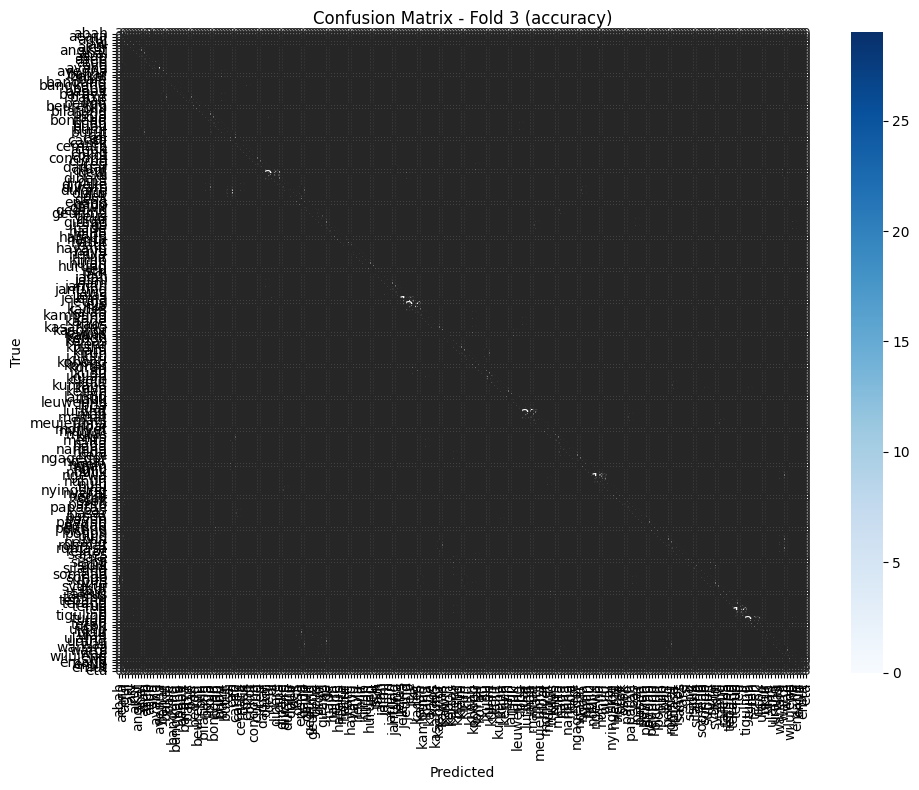


Evaluating Fold 4 - accuracy model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step
F1-Score: 0.9021
              precision    recall  f1-score   support

        abah       0.86      1.00      0.92         6
       acara       1.00      1.00      1.00         3
        agul       1.00      1.00      1.00         3
          ai       1.00      1.00      1.00         3
         aki       0.50      0.67      0.57         3
        akur       1.00      0.67      0.80         3
      angkat       1.00      1.00      1.00         3
        apal       1.00      1.00      1.00         3
        asup       1.00      1.00      1.00         3
        asép       1.00      1.00      1.00         3
        atuh       1.00      1.00      1.00         3
         aya       1.00      0.83      0.91         6
       ayana       1.00      1.00      1.00         3
      ayeuna       1.00      1.00      1.00         6
       bahar       1.00      0.67      0.80         3
       bakal       1.00      1.00      1.00         3
        balé       1.00

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

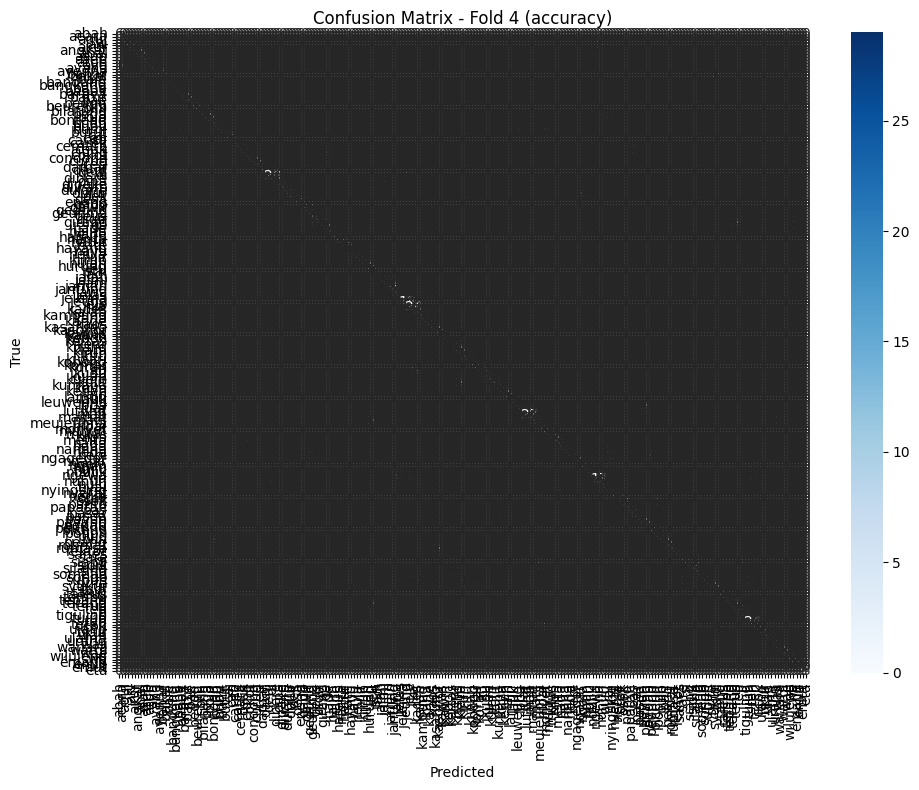


Evaluating Fold 0 - loss model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step
F1-Score: 0.8910
              precision    recall  f1-score   support

        abah       0.60      1.00      0.75         6
       acara       1.00      1.00      1.00         3
        agul       0.75      1.00      0.86         3
          ai       1.00      0.67      0.80         3
         aki       0.33      0.67      0.44         3
        akur       1.00      0.67      0.80         3
      angkat       1.00      1.00      1.00         3
        apal       1.00      1.00      1.00         3
        asup       1.00      1.00      1.00         3
        asép       1.00      1.00      1.00         3
        atuh       1.00      0.67      0.80         3
         aya       0.86      1.00      0.92         6
       ayana       1.00      1.00      1.00         3
      ayeuna       1.00      0.83      0.91         6
       bahar       0.75      1.00      0.86         3
       bakal       1.00      1.00      1.00         3
        balé       1.00

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

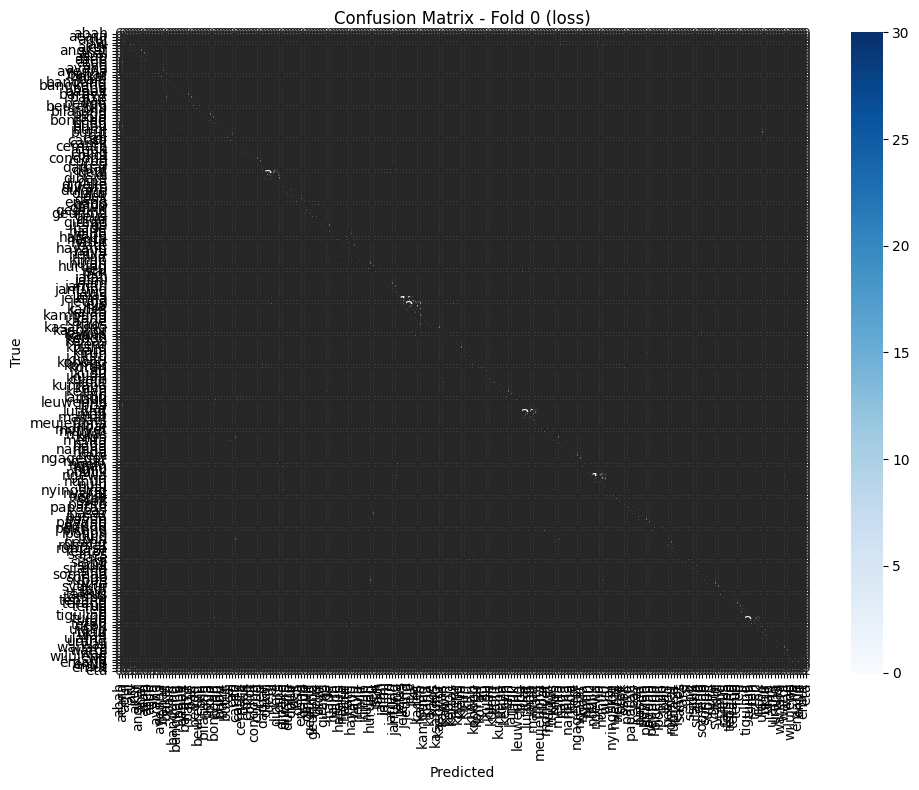


Evaluating Fold 1 - loss model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step
F1-Score: 0.8640
              precision    recall  f1-score   support

        abah       0.83      0.83      0.83         6
       acara       1.00      1.00      1.00         3
        agul       0.75      1.00      0.86         3
          ai       1.00      1.00      1.00         3
         aki       0.33      0.67      0.44         3
        akur       0.00      0.00      0.00         3
      angkat       0.75      1.00      0.86         3
        apal       1.00      1.00      1.00         3
        asup       1.00      1.00      1.00         3
        asép       1.00      1.00      1.00         3
        atuh       0.75      1.00      0.86         3
         aya       1.00      0.67      0.80         6
       ayana       0.75      1.00      0.86         3
      ayeuna       1.00      0.83      0.91         6
       bahar       0.50      0.33      0.40         3
       bakal       1.00      1.00      1.00         3
        balé       0.8

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

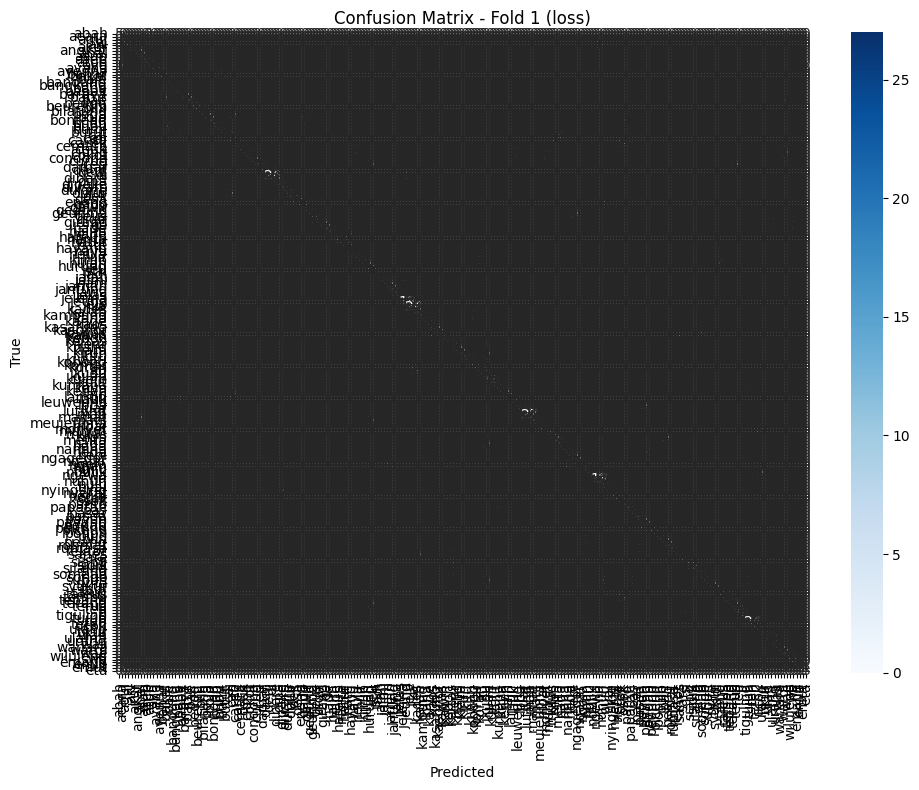


Evaluating Fold 2 - loss model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step
F1-Score: 0.8842
              precision    recall  f1-score   support

        abah       1.00      0.83      0.91         6
       acara       1.00      1.00      1.00         3
        agul       0.67      0.67      0.67         3
          ai       0.75      1.00      0.86         3
         aki       0.00      0.00      0.00         3
        akur       0.50      1.00      0.67         3
      angkat       0.75      1.00      0.86         3
        apal       1.00      1.00      1.00         3
        asup       0.75      1.00      0.86         3
        asép       1.00      1.00      1.00         3
        atuh       0.75      1.00      0.86         3
         aya       1.00      0.83      0.91         6
       ayana       1.00      1.00      1.00         3
      ayeuna       1.00      1.00      1.00         6
       bahar       0.75      1.00      0.86         3
       bakal       1.00      1.00      1.00         3
        balé       0.71

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

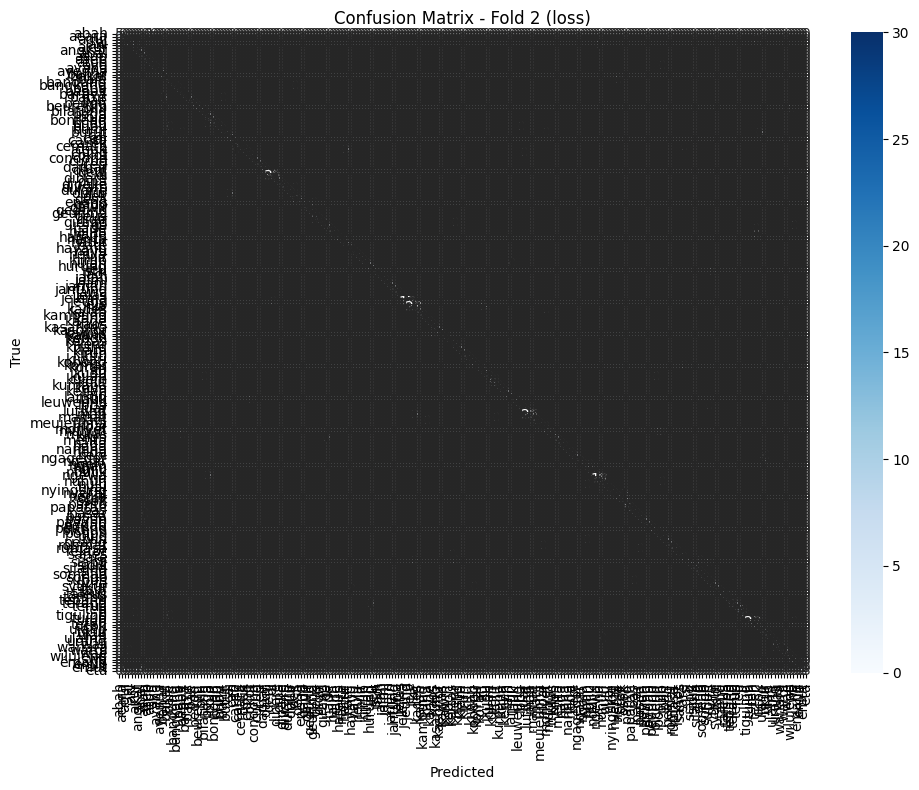


Evaluating Fold 3 - loss model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step
F1-Score: 0.8601
              precision    recall  f1-score   support

        abah       1.00      1.00      1.00         6
       acara       1.00      1.00      1.00         3
        agul       0.75      1.00      0.86         3
          ai       1.00      1.00      1.00         3
         aki       0.40      0.67      0.50         3
        akur       1.00      0.33      0.50         3
      angkat       1.00      1.00      1.00         3
        apal       1.00      1.00      1.00         3
        asup       1.00      1.00      1.00         3
        asép       1.00      1.00      1.00         3
        atuh       1.00      0.67      0.80         3
         aya       1.00      1.00      1.00         6
       ayana       0.75      1.00      0.86         3
      ayeuna       1.00      0.83      0.91         6
       bahar       0.50      0.67      0.57         3
       bakal       0.75      1.00      0.86         3
        balé       1.00

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

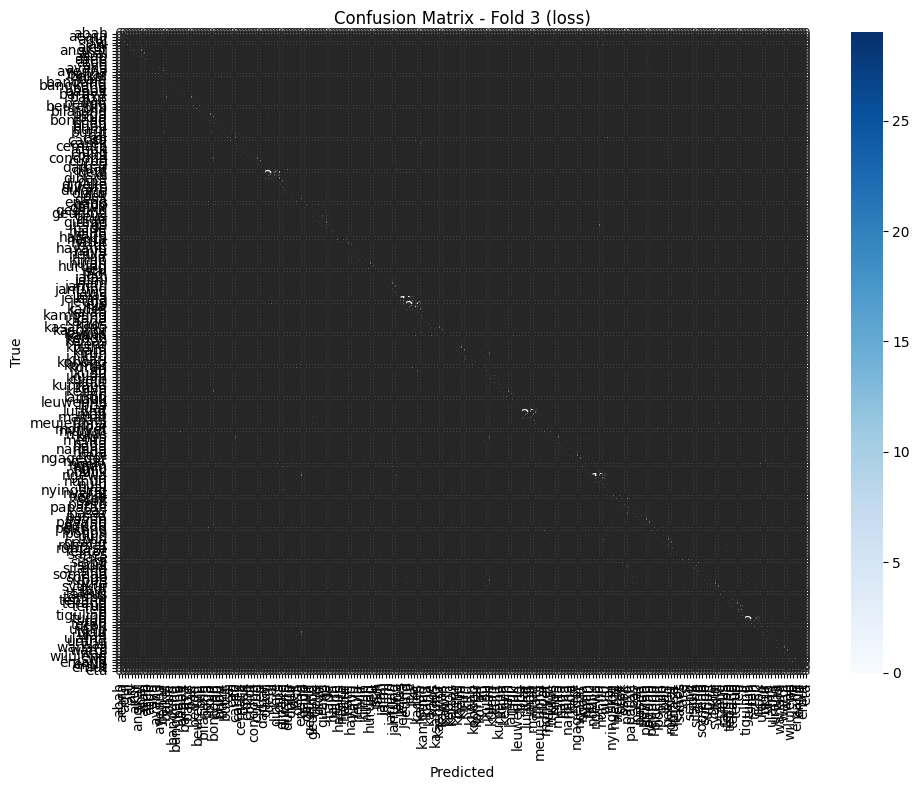


Evaluating Fold 4 - loss model...


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step
F1-Score: 0.9021
              precision    recall  f1-score   support

        abah       0.86      1.00      0.92         6
       acara       1.00      1.00      1.00         3
        agul       1.00      1.00      1.00         3
          ai       1.00      1.00      1.00         3
         aki       0.50      0.67      0.57         3
        akur       1.00      0.67      0.80         3
      angkat       1.00      1.00      1.00         3
        apal       1.00      1.00      1.00         3
        asup       1.00      1.00      1.00         3
        asép       1.00      1.00      1.00         3
        atuh       1.00      1.00      1.00         3
         aya       1.00      0.83      0.91         6
       ayana       1.00      1.00      1.00         3
      ayeuna       1.00      1.00      1.00         6
       bahar       1.00      0.67      0.80         3
       bakal       1.00      1.00      1.00         3
        balé       1.00

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

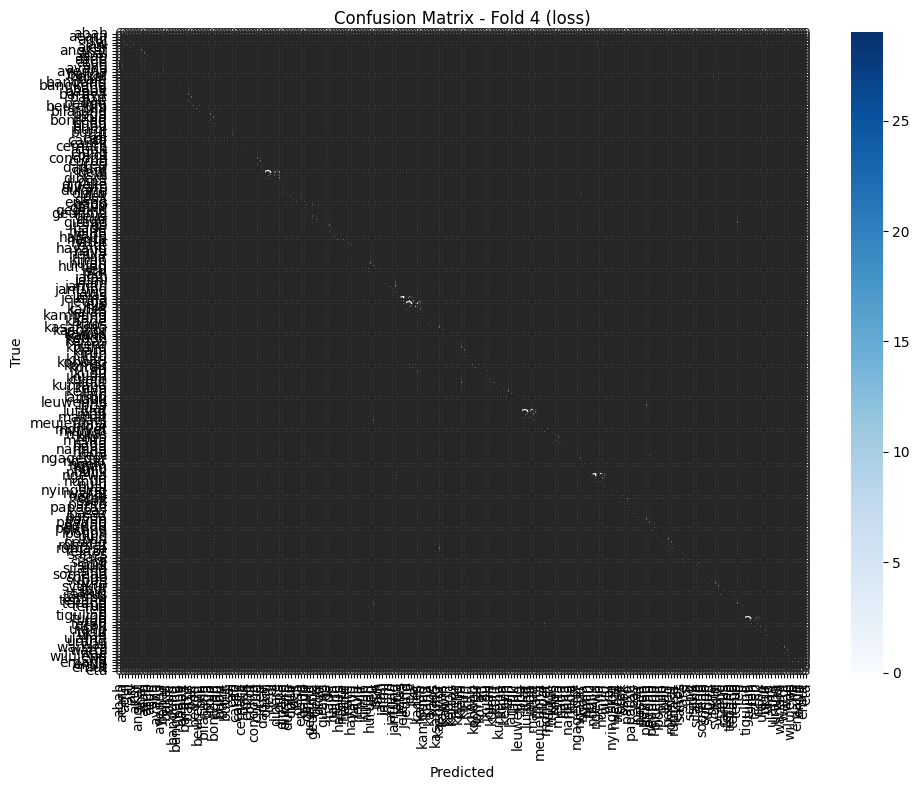

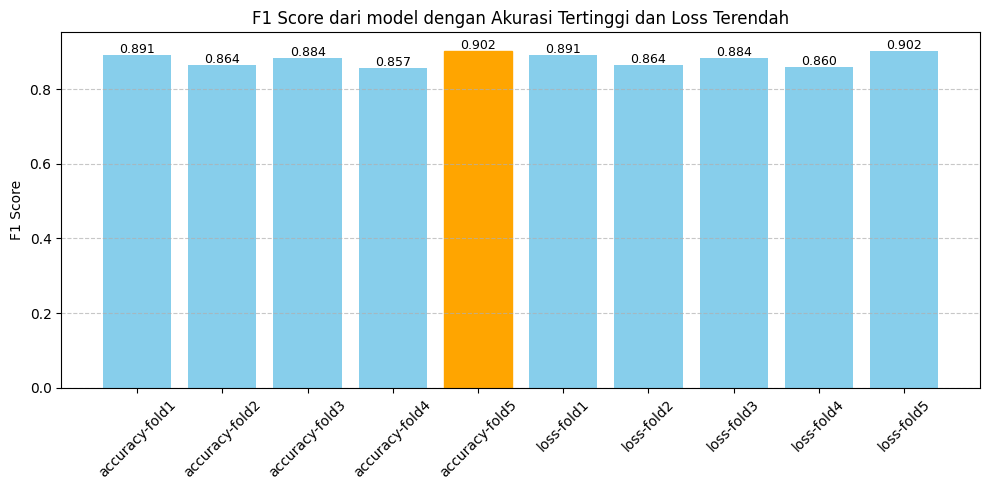


🏆 Model terbaik secara keseluruhan adalah: Fold 5 - accuracy model
📈 F1-Score: 0.9021
📁 Path: saved_model_finetune_v2/fold_4/best_accuracy_model.h5


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Konfigurasi
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_FOLDS = 5
TEST_DIR = "Datasets/model2/validation"  # Test set path
CLASS_NAMES = sorted(os.listdir("Datasets/model2/training"))  # Ambil classnames dari training

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluasi seluruh model dan cari model terbaik tunggal berdasarkan F1-score
model_scores = []

for mode in ["accuracy", "loss"]:
    for fold in range(NUM_FOLDS):
        model_path = f"saved_model_finetune_v2/fold_{fold}/best_{mode}_model.h5"
        if not os.path.exists(model_path):
            print(f"Model not found: {model_path}")
            continue

        print(f"\nEvaluating Fold {fold} - {mode} model...")
        model = load_model(model_path)
        predictions = model.predict(test_generator)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_generator.classes

        cm = confusion_matrix(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"F1-Score: {f1:.4f}")
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

        model_scores.append({
            'fold': fold + 1,
            'mode': mode,
            'f1_score': f1,
            'model_path': model_path
        })

        # Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
        plt.title(f"Confusion Matrix - Fold {fold} ({mode})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

# Visualisasi semua F1-score
fold_labels = [f"{d['mode']}-fold{d['fold']}" for d in model_scores]
f1_scores = [d['f1_score'] for d in model_scores]
max_idx = np.argmax(f1_scores)

plt.figure(figsize=(10, 5))
bars = plt.bar(fold_labels, f1_scores, color='skyblue')
bars[max_idx].set_color('orange')
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.3f}", ha='center', fontsize=9)

plt.title("F1 Score dari model dengan Akurasi Tertinggi dan Loss Terendah")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.ylim(0, max(f1_scores) + 0.05)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Tampilkan model terbaik secara keseluruhan
best_model = model_scores[max_idx]
print(f"\n🏆 Model terbaik secara keseluruhan adalah: Fold {best_model['fold']} - {best_model['mode']} model")
print(f"📈 F1-Score: {best_model['f1_score']:.4f}")
print(f"📁 Path: {best_model['model_path']}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


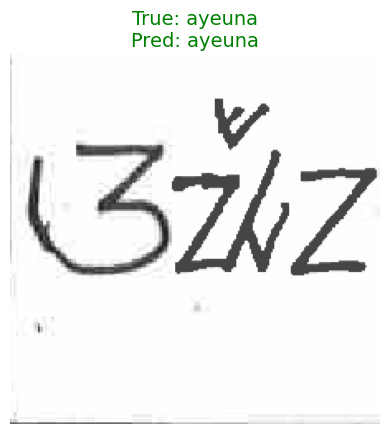

✅ Label Prediksi: ayeuna
✅ Label Sebenarnya: ayeuna


In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os

model_loaded = load_model('saved_models_2_kernelreg/fold_3/best_accuracy_model.h5')


def predict_single_image(img_path, model, class_names, img_size=224):
    # Ambil label sebenarnya dari nama folder
    true_label = os.path.basename(os.path.dirname(img_path))

    # Load dan preproses gambar
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimensi

    # Prediksi
    pred_probs = model.predict(img_array)
    pred_index = np.argmax(pred_probs)
    predicted_label = class_names[pred_index]

    # Visualisasi hasil
    plt.imshow(img)
    plt.axis('off')
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=14)
    plt.show()

    return predicted_label, true_label

# img_path = 'Datasets/model1/validation/ca/ca (1).png'  
img_path = 'Datasets/model2/validation/ayeuna/1.png'  
pred, true = predict_single_image(img_path, model_loaded, class_names)
print("✅ Label Prediksi:", pred)
print("✅ Label Sebenarnya:", true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


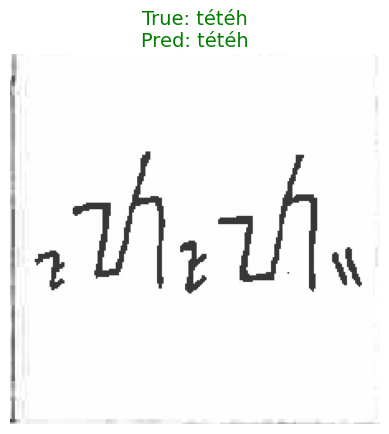

✅ Label Prediksi: tétéh
✅ Label Sebenarnya: tétéh


In [8]:
img_path = 'Datasets/model2/validation/tétéh/3.png'  
pred, true = predict_single_image(img_path, model_loaded, class_names)
print("✅ Label Prediksi:", pred)
print("✅ Label Sebenarnya:", true)